### Recurrent Neural Networks

$\mathrm{AR}$ 모형의 일반화된 과정으로써의 $\mathrm{RNN}$ Network를 알아보도록 한다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

from recurrent_neural_network import *

Using TensorFlow backend.
Using TensorFlow backend.


ImportError: cannot import name 'transpose_shape' from 'keras.utils.generic_utils' (/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/keras/utils/generic_utils.py)

#### Data Import

In [5]:
df = pd.read_csv('../data/coinbase.csv', index_col = 1)
df.index = pd.to_datetime(df.index, infer_datetime_format = True)

In [6]:
df

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931
...,...
2018-11-10 15:56:00,6347.417225
2018-11-10 15:57:00,6347.419294
2018-11-10 15:58:00,6347.418653


data preprocessing

In [7]:
nof_missing_values = sum(np.isnan(df['USD']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [8]:
df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['USD']))
print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


#### RNN Regression

시계열이 Data Frame에서 'USD'로 주어지고 각 입력 시퀀스에 대해 미래의 4개의 시간 단계로 값을 예측하는 단변량 예측 문제를 고려한다

In [9]:
use_features = ['USD'] # continuous input
target = ['USD'] # continuous output
n_steps_ahead = 4 # forecasting horizon

In [10]:
sample = df['USD'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [11]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.0945571633757587
p-value: 0.2467088183939536,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


ADF 검정을 통과하지 못하였음으로, 불안정 시계열이다

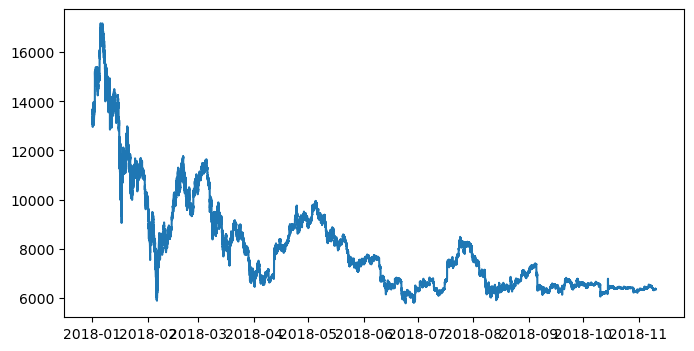

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,4))
plt.plot(df)
plt.show()

**Partial Auto-correlation**

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [14]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

 $\Phi^{-1}(0.99) \simeq 2.58$ 이기 때문에, 다음이 성립한다

In [15]:
T = len(df[use_features])
sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [16]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


Text(0.5, 1.0, 'Partial Autocorrelation function')

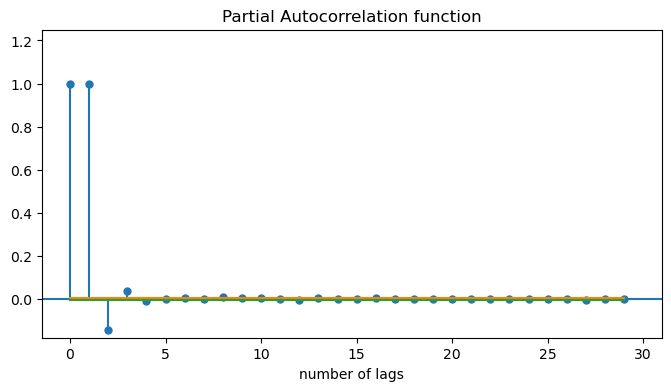

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(np.log(df), auto_ylims = True, lags = 29, title = 'PACF of KOSPI log Index', ax = ax)
plt.xlabel('number of lags')
plt.plot([2.58/np.sqrt(T)] * 30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)] * 30, label='99% confidence interval (lower)')
plt.title('Partial Autocorrelation function')

train - test split

In [24]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]